# Visualization Filters

In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np
model = VGG16(weights='imagenet', include_top=False)
layer_name = 'block5_conv1'
filter_index = 1
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
grads = K.gradients(loss, model.input)[0]

In [ ]:
grads /= (K.sqrt(K.mean(K.square(grads)))+ 1e-5)

In [ ]:
iterate = K.function([model.input],
                     [loss,grads])

In [ ]:
input_img_data = np.random.random((1,150,150,3)) *20+128
step = 1
for i in range(40):
  loss_value , grads_value = iterate([input_img_data])
  input_img_data += grads_value * step

In [ ]:
def deprocess_image(x):
  x -= x.mean()
  x /= (x.std()+1e-5)
  x *= 0.1
  x += 0.5
  x = np.clip(x,0,1)
  x *=255
  x = np.clip(x,0,255).astype('uint8')
  return x

In [ ]:
img = input_img_data[0]

In [ ]:
img = deprocess_image(img)

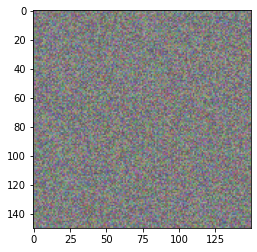

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(img)

# CAM Visualization
Class Activation Heatmap

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')


553467904/553467096 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'a.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [ ]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


40960/35363 [==================================] - 0s 0us/step
Predicted: [('n02504458', 'African_elephant', 0.70109075), ('n01871265', 'tusker', 0.25578338), ('n02504013', 'Indian_elephant', 0.042951804)]


In [ ]:
african_e66lephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')

grads = K.gradients(african_e66lephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input],
                     [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

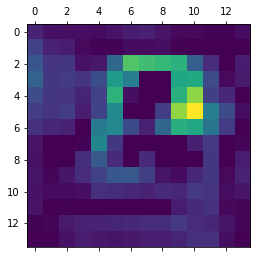

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [ ]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('elephant.jpg', superimposed_img)

True

## Listing 8.8 Loading the pretrained Inception V3 model

In [2]:
from keras.applications import inception_v3
from keras import backend as K

K.set_learning_phase(0)

model = inception_v3.InceptionV3(weights='imagenet',
include_top=False)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


### Listing 8.9 Setting up the DeepDream configuration

In [3]:
layer_contributions = {
'mixed2': 0.2,
'mixed3': 3.,
'mixed4': 2.,
'mixed5': 1.5,
}

In [4]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

## Listing 8.10 Defining the loss to be maximized

In [5]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

loss = K.variable(0.)

for layer_name in layer_contributions:
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

## Listing 8.11 Gradient-ascent process

In [8]:
dream = model.input

grads = K.gradients(loss, dream)[0]

grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]

fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x): 
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('... loss value at ', i, ':', loss_value)
        x += step * grad_values
    return x


## Listing 8.13 Auxiliary functions

In [9]:
! pip install scipy==1.1.0

In [10]:
import scipy
from keras.preprocessing import image


def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

# the main code


## Listing 8.12 Running gradient ascent over different successive scales

In [11]:
import numpy as np 

step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10.

base_img_path = '/content/dream.jpeg'

img = preprocess_image(base_img_path)

original_shape = img.shape[1:3]

successive_shapes = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]

original_image = np.copy(img)

shrunk_original_image = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing shape: ', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss)

    upscaled_shrunk_original_img = resize_img(shrunk_original_image, shape)

    same_original_size = resize_img(shrunk_original_image, shape)

    lost_detail = same_original_size - upscaled_shrunk_original_img

    img += lost_detail

    shrunk_original_image = resize_img(original_image, shape)

    save_img(img, fname='../dream_at_scale_' + str(shape) + '.png')


save_img(img, fname='/content/final_dream.png')


Processing shape:  (612, 918)
... loss value at  0 : 1.9551514
... loss value at  1 : 2.4290752
... loss value at  2 : 3.091895
... loss value at  3 : 3.8282557
... loss value at  4 : 4.5352097
... loss value at  5 : 5.249285
... loss value at  6 : 5.949575
... loss value at  7 : 6.639184
... loss value at  8 : 7.305341
... loss value at  9 : 7.9425173
... loss value at  10 : 8.587061
... loss value at  11 : 9.215421
... loss value at  12 : 9.828358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning:     `imsave` is deprecated!
    `imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imwrite`` instead.
  app.launch_new_instance()


Processing shape:  (857, 1285)
... loss value at  0 : 3.106443
... loss value at  1 : 4.331673
... loss value at  2 : 5.412072
... loss value at  3 : 6.36928
... loss value at  4 : 7.2694263
... loss value at  5 : 8.140337
... loss value at  6 : 8.936568
... loss value at  7 : 9.712341


/usr/local/lib/python3.7/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Processing shape:  (1200, 1800)
... loss value at  0 : 3.3410008
... loss value at  1 : 4.58126
... loss value at  2 : 5.6432667
... loss value at  3 : 6.616824
... loss value at  4 : 7.5440254
... loss value at  5 : 8.424098
... loss value at  6 : 9.258959
